<a href="https://colab.research.google.com/github/Lataborda/MEC-LDA_TRICOT/blob/main/MEC_Rechazo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import csv, re, pandas as pd

CSV_PATH = "/content/P21_column_extracted.csv"  # ajusta si hace falta

# Detectar delimitador
with open(CSV_PATH, 'r', encoding='utf-8', errors='ignore') as f:
    sample = f.read(8192)
    try:
        dialect = csv.Sniffer().sniff(sample, delimiters=[',',';','\t','|'])
        delim = dialect.delimiter
    except Exception:
        delim = ','

print("Delimitador:", repr(delim))

# Lectura tolerante
try:
    df = pd.read_csv(CSV_PATH, sep=None, engine="python", encoding="utf-8-sig")
    print("Leído con sep=None")
except Exception:
    df = pd.read_csv(
        CSV_PATH, delimiter=delim, engine="python",
        encoding="utf-8-sig", quotechar='"', escapechar='\\',
        on_bad_lines="skip"
    )
    print("Leído con delimiter detectado y on_bad_lines='skip'")

# Asegura columnas esperadas
if "Worst" not in df.columns or "P21" not in df.columns:
    raise ValueError(f"Columnas esperadas no encontradas. Vistas: {list(df.columns)}")

# Normalizados para el modelo
def norm_str(s):
    s = str(s).strip().lower()
    s = re.sub(r"\s+", " ", s)
    return s

df["Worst_norm"] = df["Worst"].map(norm_str)
df["P21_norm"]   = df["P21"].map(norm_str)

df.head(3)


Delimitador: ';'
Leído con sep=None


,Worst,P21,Worst_norm,P21_norm
0,Rapidita,no es comercial por el color ...,rapidita,no es comercial por el color
1,La Amarilla,no tiene rendimiento y no es comercial en la z...,la amarilla,no tiene rendimiento y no es comercial en la zona
2,La rendidora,No es comercial ...,la rendidora,no es comercial


In [7]:
import json, re

SCHEMA_PATH = "/content/mec_schema_v02_fixed.json"  # ajusta ruta/nombre

with open(SCHEMA_PATH, "r", encoding="utf-8") as f:
    schema = json.load(f)

def norm(s: str) -> str:
    s = str(s).lower().strip()
    s = re.sub(r"\s+", " ", s)
    return s

def defs_from_schema(items):
    out = {}
    for cat in items:
        name_raw = cat.get("name", "").strip()
        name = norm(name_raw)
        inc = cat.get("include_terms") or []
        inc = [norm(x) for x in inc if x]

        # Fallbacks si faltan include_terms: definición + sinónimos en paréntesis
        extras = []
        defin = norm(cat.get("definition", ""))
        if defin:
            extras += re.findall(r"[a-záéíóúñü]+", defin)
        paren = re.findall(r"\((.*?)\)", name_raw, flags=re.IGNORECASE)
        for p in paren:
            parts = re.split(r"[,/;]| vs |–|-", p.lower())
            extras += [norm(w) for w in parts if w and len(w.strip()) > 1]

        coverage = " ".join(sorted(set([name] + inc + extras)))
        out[name] = coverage if coverage.strip() else name
    return out

A_DEFS = defs_from_schema(schema["A"])
C_DEFS = defs_from_schema(schema["C"])
V_DEFS = defs_from_schema(schema["V"])

print("A:", len(A_DEFS), "C:", len(C_DEFS), "V:", len(V_DEFS))
list(A_DEFS.items())[:3]  # vista previa


A: 15 C: 11 V: 9


[('color de pulpa',
  'al amarilla blanca color amarillo color de la pulpa color de pulpa color llamativo color poco apetecible comprador de del en influye interna la muy llamativo no es comercial por el color observable partirla poco atractivo por el color por su color amarillo por su color no tiene mercado preferencia pulpa amarilla que raíz tonalidad vs yuca blanca'),
 ('tipo de sabor (dulce vs amarga)',
  'a al amarga amarma (error) asociado carácter consumo de de mesa dulce gustativo industrial la mesa más amarga que dulce no vendo amarga o para consumo percibido sabe amarga sabor dulce su tipo de sabor (dulce vs amarga) uso variedad yuca amarga'),
 ('rendimiento en campo',
  '20 o 30% a baja produccion baja producción cantidad de frente menor rendimiento menos producción no rinde no tiene un rendimiento superior o otras por porcentaje porcentaje de produccion porcentaje de producción producción relativo rendimiento en campo rinde menos se queda corta (en producción) variedades ár

In [10]:
import os, re, pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Stopwords simples
STOP = set("""de la que el en y a los del se las por un para con no una su al lo como mas pero sus le ya o este si porque esta entre cuando muy sin sobre tambien me hasta hay donde quien desde toda nos durante todos uno les ni contra otros ese eso ante ellos e esto mi antes algunos que yo mi tu te ti tuya suyo suya suyos suyas nuestras nuestros nuestras vuestro vuestra vuestros vuestras es son fue fueron era eran sera seran seria serian soy somos sois""".split())

def norm_txt(s):
    s = str(s).lower()
    s = re.sub(r"[^a-záéíóúñü0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    toks = [t for t in s.split() if t not in STOP and len(t) > 1]
    return " ".join(toks)

def build_label_docs(label_defs: dict):
    names = list(label_defs.keys())
    docs = [norm_txt(label_defs[k]) for k in names]
    return names, docs

def multilabel_assign(text: str, label_names, label_docs, threshold=0.12, topk=3):
    corpus = label_docs + [norm_txt(text)]
    vec = TfidfVectorizer(min_df=1, ngram_range=(1,2))
    X = vec.fit_transform(corpus)
    sims = cosine_similarity(X[-1], X[:-1]).ravel()
    ranked = sorted(zip(label_names, sims), key=lambda x: x[1], reverse=True)
    selected = [lab for lab, sc in ranked if sc >= threshold][:topk]
    if not selected and ranked:
        selected = [ranked[0][0]]
    return selected

A_NAMES, A_DOCS = build_label_docs(A_DEFS)
C_NAMES, C_DOCS = build_label_docs(C_DEFS)
V_NAMES, V_DOCS = build_label_docs(V_DEFS)

rows = []
for i, r in df.iterrows():
    full_txt = (r["Worst_norm"] + " " + r["P21_norm"]).strip()
    A = multilabel_assign(full_txt, A_NAMES, A_DOCS, threshold=0.12, topk=3)
    C = multilabel_assign(full_txt, C_NAMES, C_DOCS, threshold=0.12, topk=3)
    V = multilabel_assign(full_txt, V_NAMES, V_DOCS, threshold=0.12, topk=3)
    rows.append({"row_id": i, "Worst": r["Worst"], "P21": r["P21"],
                 "A_labels": A, "C_labels": C, "V_labels": V})

coded_df = pd.DataFrame(rows)

# Expandir tripletas y contar
triples = []
for _, r in coded_df.iterrows():
    for a in r["A_labels"]:
        for c in r["C_labels"]:
            for v in r["V_labels"]:
                triples.append((a,c,v))
triples_df = pd.DataFrame(triples, columns=["A","C","V"])
triples_df["count"] = 1

edge_AC = triples_df.groupby(["A","C"], as_index=False)["count"].sum().sort_values("count", ascending=False)
edge_CV = triples_df.groupby(["C","V"], as_index=False)["count"].sum().sort_values("count", ascending=False)

imp_AC = edge_AC.pivot_table(index="A", columns="C", values="count", fill_value=0)
imp_CV = edge_CV.pivot_table(index="C", columns="V", values="count", fill_value=0)

# Guardar
outdir = "/content/mec_outputs_text_only"
os.makedirs(outdir, exist_ok=True)
coded_df.to_csv(f"{outdir}/coded_rows.csv", index=False)
edge_AC.to_csv(f"{outdir}/edge_list_AC.csv", index=False)
edge_CV.to_csv(f"{outdir}/edge_list_CV.csv", index=False)
imp_AC.to_csv(f"{outdir}/implication_matrix_AC.csv")
imp_CV.to_csv(f"{outdir}/implication_matrix_CV.csv")

print("Listo:", outdir)
display(edge_AC.head(10)); display(edge_CV.head(10)); coded_df.head(3)


Listo: /content/mec_outputs_text_only


,A,C,count
45,segmento de uso/mercado,dificultad de comercialización,69
19,color de pulpa,dificultad de comercialización,61
2,adaptación al clima/zona,dificultad de comercialización,37
23,color de pulpa,rechazo del consumidor,32
37,rendimiento en campo,baja productividad,21
29,impacto percibido en el suelo,impacto negativo en el suelo,21
3,adaptación al clima/zona,fallas de adaptación,17
55,tipo de sabor (dulce vs amarga),dificultad de comercialización,16
38,rendimiento en campo,dificultad de comercialización,14
57,tipo de sabor (dulce vs amarga),rechazo del consumidor,14


,C,V,count
15,dificultad de comercialización,aceptación del mercado,99
21,dificultad de comercialización,rentabilidad sostenida,56
17,dificultad de comercialización,compatibilidad con condiciones locales,32
38,rechazo del consumidor,aceptación del mercado,30
28,impacto negativo en el suelo,cuidado del suelo y sostenibilidad,27
24,fallas de adaptación,compatibilidad con condiciones locales,24
20,dificultad de comercialización,estabilidad del desempeño,18
37,oportunidad de rotación limitada,eficiencia temporal,16
41,rechazo del consumidor,estabilidad del desempeño,13
47,riesgo por desconocimiento,seguridad y certeza,10


,row_id,Worst,P21,A_labels,C_labels,V_labels
0,0,Rapidita,no es comercial por el color ...,[color de pulpa],[dificultad de comercialización],[aceptación del mercado]
1,1,La Amarilla,no tiene rendimiento y no es comercial en la z...,"[adaptación al clima/zona, rendimiento en campo]",[dificultad de comercialización],[aceptación del mercado]
2,2,La rendidora,No es comercial ...,[calibre/forma de raíz],[dificultad de comercialización],[aceptación del mercado]


from matplotlib import pyplot as plt
_df_0['row_id'].plot(kind='hist', bins=20, title='row_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('Worst').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('P21').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['row_id']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'row_id'}, axis=1)
              .sort_values('row_id', ascending=True))
  xs = counted['row_id']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('row_id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Worst')):
  _plot_series(series, series_name, i)
  fig.legend(title='Worst', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('row_id')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['row_id']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'row_id'}, axis=1)
              .sort_values('row_id', ascending=True))
  xs = counted['row_id']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('row_id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('P21')):
  _plot_series(series, series_name, i)
  fig.legend(title='P21', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('row_id')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_5['row_id'].plot(kind='line', figsize=(8, 4), title='row_id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['P21'].value_counts()
    for x_label, grp in _df_6.groupby('Worst')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Worst')
_ = plt.ylabel('P21')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_7['Worst'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_7, x='row_id', y='Worst', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_8['P21'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_8, x='row_id', y='P21', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


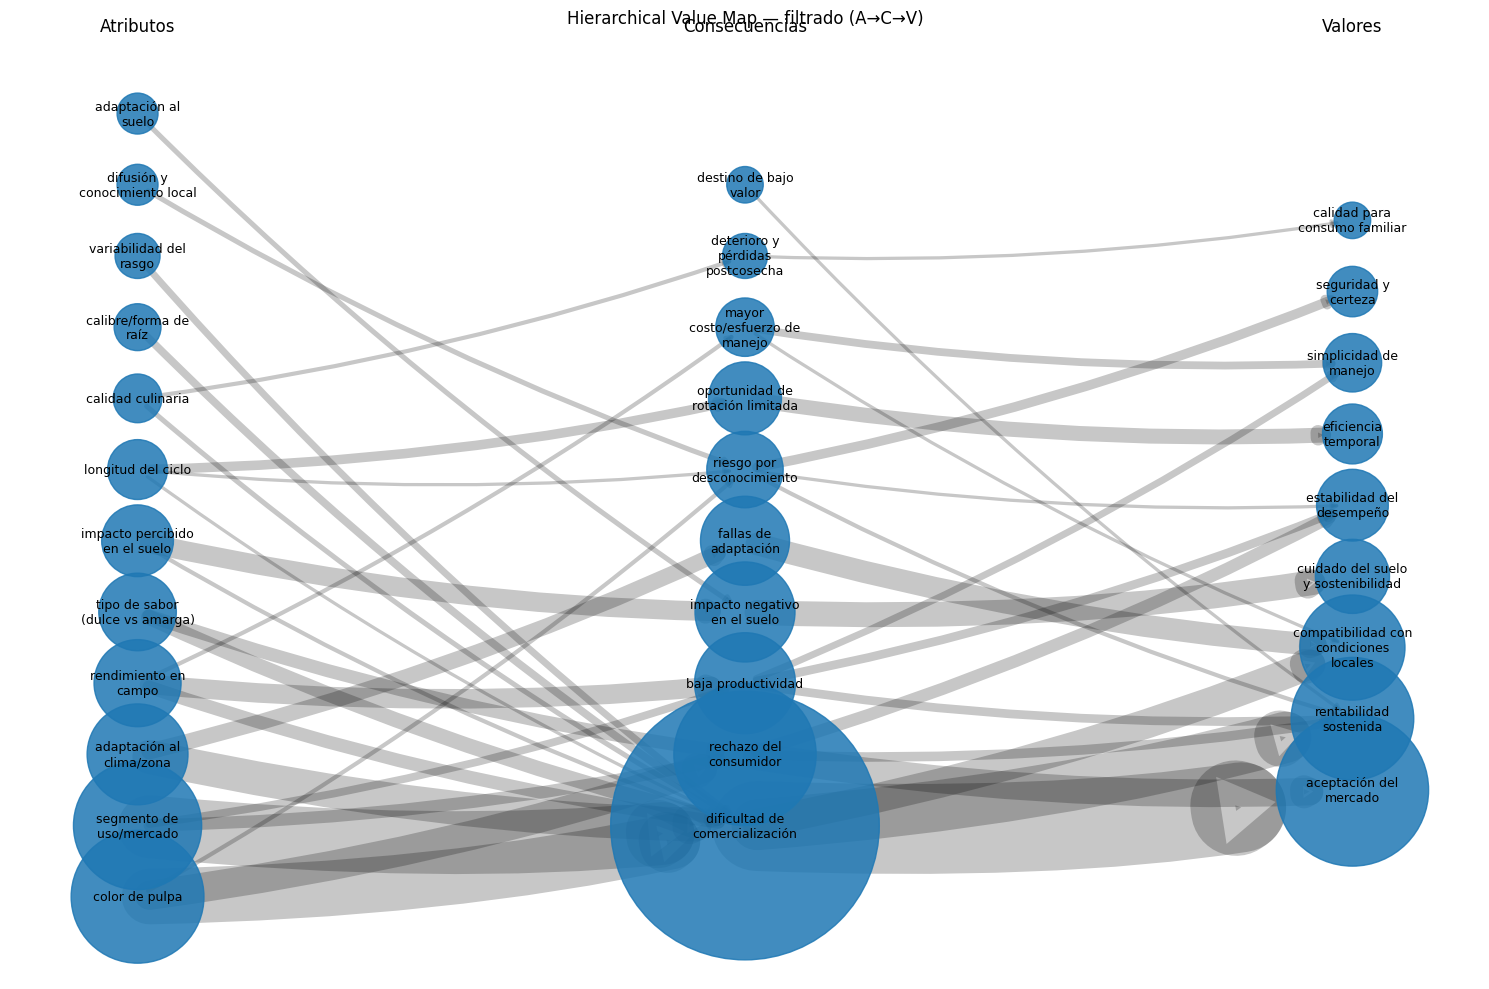

Guardado: /content/mec_outputs_text_only/HVM_filtrado_tenue.png y /content/mec_outputs_text_only/HVM_filtrado_tenue.svg


In [13]:
# === HVM legible para paper: flechas tenues, textos centrados y títulos por columna ===
import os, textwrap, numpy as np, pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

outdir = "/content/mec_outputs_text_only"
if 'edge_AC' not in globals() or 'edge_CV' not in globals():
    edge_AC = pd.read_csv(f"{outdir}/edge_list_AC.csv")
    edge_CV = pd.read_csv(f"{outdir}/edge_list_CV.csv")

# ---------- PARÁMETROS DE LEGIBILIDAD (ajústalos si hace falta) ----------
MIN_COUNT = 3           # umbral mínimo de frecuencia para dibujar un enlace
TOPK_PER_A = 3          # máximo enlaces A->C por cada A
TOPK_PER_C_to_V = 3     # máximo enlaces C->V por cada C
TOP_A = 12              # máximo nodos A
TOP_C = 12              # máximo nodos C
TOP_V = 9               # máximo nodos V

NODE_BASE = 420         # tamaño base de nodos
NODE_K    = 90          # sensibilidad del tamaño al peso
EDGE_BASE = 0.4         # grosor base de flecha
EDGE_K    = 0.65        # sensibilidad del grosor a la frecuencia
EDGE_ALPHA = 0.22       # transparencia de flechas (más bajo = más tenue)
NODE_ALPHA = 0.85       # transparencia de nodos

LABEL_WRAP = 18         # ancho de envoltura (caracteres) para el texto del nodo
LABEL_SIZE = 9          # tamaño de letra

# ---------- FILTRADO Y TOPS ----------
AC = edge_AC[edge_AC["count"] >= MIN_COUNT].copy()
CV = edge_CV[edge_CV["count"] >= MIN_COUNT].copy()

AC = (AC.sort_values(["A","count"], ascending=[True,False])
        .groupby("A", as_index=False).head(TOPK_PER_A))
CV = (CV.sort_values(["C","count"], ascending=[True,False])
        .groupby("C", as_index=False).head(TOPK_PER_C_to_V))

wA = AC.groupby("A")["count"].sum().sort_values(ascending=False)
wC = pd.concat([AC.groupby("C")["count"].sum(),
                CV.groupby("C")["count"].sum()], axis=1).fillna(0).sum(1).sort_values(ascending=False)
wV = CV.groupby("V")["count"].sum().sort_values(ascending=False)

A_keep = set(wA.head(TOP_A).index)
C_keep = set(wC.head(TOP_C).index)
V_keep = set(wV.head(TOP_V).index)

AC = AC[AC["A"].isin(A_keep) & AC["C"].isin(C_keep)]
CV = CV[CV["C"].isin(C_keep) & CV["V"].isin(V_keep)]

# Recalcular pesos tras filtrado
wA = AC.groupby("A")["count"].sum()
wC = pd.concat([AC.groupby("C")["count"].sum(),
                CV.groupby("C")["count"].sum()], axis=1).fillna(0).sum(1)
wV = CV.groupby("V")["count"].sum()

# ---------- GRAFO EN CAPAS ----------
G = nx.DiGraph()
for a in wA.index: G.add_node(("A",a), weight=wA[a])
for c in wC.index: G.add_node(("C",c), weight=wC[c])
for v in wV.index: G.add_node(("V",v), weight=wV[v])

for _, r in AC.iterrows():
    G.add_edge(("A", r["A"]), ("C", r["C"]), weight=r["count"])
for _, r in CV.iterrows():
    G.add_edge(("C", r["C"]), ("V", r["V"]), weight=r["count"])

def layered_positions(G, gap_x=4.6, gap_y=1.25):
    A_nodes = [n for n in G.nodes() if n[0]=="A"]
    C_nodes = [n for n in G.nodes() if n[0]=="C"]
    V_nodes = [n for n in G.nodes() if n[0]=="V"]

    def y_coords(nodes):
        w = [G.nodes[n].get("weight",1.0) for n in nodes]
        order = np.argsort(-np.array(w))
        nodes_sorted = [nodes[i] for i in order]
        y = np.linspace(0, gap_y*(len(nodes_sorted)-1), len(nodes_sorted)) if nodes_sorted else []
        if len(y)>0: y = y - np.mean(y)
        return nodes_sorted, y

    A_sorted, yA = y_coords(A_nodes)
    C_sorted, yC = y_coords(C_nodes)
    V_sorted, yV = y_coords(V_nodes)

    pos = {}
    for node, yy in zip(A_sorted, yA): pos[node] = (0.0, yy)
    for node, yy in zip(C_sorted, yC): pos[node] = (gap_x, yy)
    for node, yy in zip(V_sorted, yV): pos[node] = (2*gap_x, yy)
    return pos

pos = layered_positions(G)

# Utilidad: tamaño de nodo y etiqueta envuelta
def node_size(n):
    w = G.nodes[n].get("weight",1.0)
    return NODE_BASE + NODE_K * w

labels = {n: "\n".join(textwrap.wrap(n[1], LABEL_WRAP)) for n in G.nodes()}

# ---------- DIBUJO ----------
plt.figure(figsize=(15,10))

# Nodos (sin fijar colores específicos)
nx.draw_networkx_nodes(G, pos,
    nodelist=[n for n in G.nodes() if n[0]=="A"],
    node_size=[node_size(n) for n in G.nodes() if n[0]=="A"],
    alpha=NODE_ALPHA)
nx.draw_networkx_nodes(G, pos,
    nodelist=[n for n in G.nodes() if n[0]=="C"],
    node_size=[node_size(n) for n in G.nodes() if n[0]=="C"],
    alpha=NODE_ALPHA)
nx.draw_networkx_nodes(G, pos,
    nodelist=[n for n in G.nodes() if n[0]=="V"],
    node_size=[node_size(n) for n in G.nodes() if n[0]=="V"],
    alpha=NODE_ALPHA)

# Flechas más finas y tenues
edge_w = [EDGE_BASE + EDGE_K*G[u][v]['weight'] for u,v in G.edges()]
nx.draw_networkx_edges(G, pos, width=edge_w, arrows=True,
                       arrowstyle="-|>", alpha=EDGE_ALPHA,
                       connectionstyle="arc3,rad=0.05")

# Texto centrado dentro de cada círculo
nx.draw_networkx_labels(G, pos, labels=labels, font_size=LABEL_SIZE, verticalalignment='center')

# Títulos por columna
xs = [0.0, 4.6, 9.2]  # deben coincidir con layered_positions(gap_x)
y_all = [yy for (_,yy) in pos.values()]
y_top = max(y_all) if len(y_all)>0 else 0
offset = (max(y_all)-min(y_all))*0.10 if len(y_all)>0 else 2.0
plt.text(xs[0], y_top+offset, "Atributos", ha="center", va="bottom", fontsize=12)
plt.text(xs[1], y_top+offset, "Consecuencias", ha="center", va="bottom", fontsize=12)
plt.text(xs[2], y_top+offset, "Valores", ha="center", va="bottom", fontsize=12)

plt.title("Hierarchical Value Map — filtrado (A→C→V)")
plt.axis("off"); plt.tight_layout()
plt.show()

# Guardar versión para paper
os.makedirs(outdir, exist_ok=True)
plt.figure(figsize=(15,10))
nx.draw_networkx_nodes(G, pos,
    nodelist=[n for n in G.nodes() if n[0]=="A"],
    node_size=[node_size(n) for n in G.nodes() if n[0]=="A"],
    alpha=NODE_ALPHA)
nx.draw_networkx_nodes(G, pos,
    nodelist=[n for n in G.nodes() if n[0]=="C"],
    node_size=[node_size(n) for n in G.nodes() if n[0]=="C"],
    alpha=NODE_ALPHA)
nx.draw_networkx_nodes(G, pos,
    nodelist=[n for n in G.nodes() if n[0]=="V"],
    node_size=[node_size(n) for n in G.nodes() if n[0]=="V"],
    alpha=NODE_ALPHA)
nx.draw_networkx_edges(G, pos, width=edge_w, arrows=True,
                       arrowstyle="-|>", alpha=EDGE_ALPHA,
                       connectionstyle="arc3,rad=0.05")
nx.draw_networkx_labels(G, pos, labels=labels, font_size=LABEL_SIZE, verticalalignment='center')
plt.text(xs[0], y_top+offset, "Atributos", ha="center", va="bottom", fontsize=12)
plt.text(xs[1], y_top+offset, "Consecuencias", ha="center", va="bottom", fontsize=12)
plt.text(xs[2], y_top+offset, "Valores", ha="center", va="bottom", fontsize=12)
#plt.title("Hierarchical Value Map — filtrado (A→C→V)")
plt.axis("off"); plt.tight_layout()

png_path = f"{outdir}/HVM_filtrado_tenue.png"
svg_path = f"{outdir}/HVM_filtrado_tenue.svg"
plt.savefig(png_path, dpi=300, bbox_inches="tight")
plt.savefig(svg_path, bbox_inches="tight")
plt.close()
print("Guardado:", png_path, "y", svg_path)


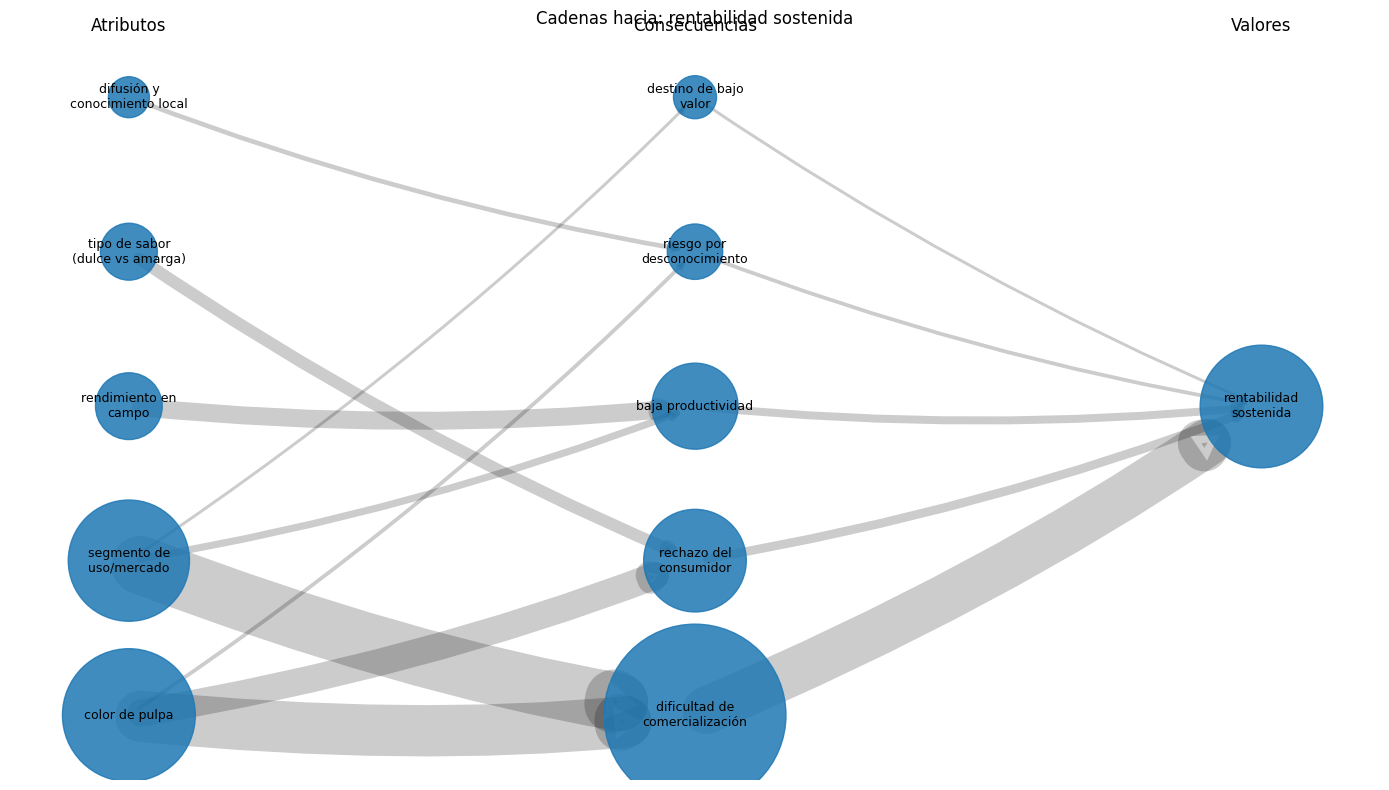

,A,C,V,AC_count,CV_count,ruta_strength
4,color de pulpa,dificultad de comercialización,rentabilidad sostenida,61,56,56
3,segmento de uso/mercado,dificultad de comercialización,rentabilidad sostenida,69,56,56
6,tipo de sabor (dulce vs amarga),rechazo del consumidor,rentabilidad sostenida,14,10,10
5,color de pulpa,rechazo del consumidor,rentabilidad sostenida,32,10,10
0,rendimiento en campo,baja productividad,rentabilidad sostenida,21,9,9
1,segmento de uso/mercado,baja productividad,rentabilidad sostenida,8,9,8
7,difusión y conocimiento local,riesgo por desconocimiento,rentabilidad sostenida,5,4,4
8,color de pulpa,riesgo por desconocimiento,rentabilidad sostenida,4,4,4
2,segmento de uso/mercado,destino de bajo valor,rentabilidad sostenida,3,3,3


In [15]:
# --- Foco en un VALOR con gráfico legible (A→C→V) ---
import os, textwrap, numpy as np, pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 1) Carga de aristas (usa tu carpeta de salida)
outdir = "/content/mec_outputs_text_only"
edge_AC = pd.read_csv(f"{outdir}/edge_list_AC.csv")
edge_CV = pd.read_csv(f"{outdir}/edge_list_CV.csv")

# 2) Parámetros del gráfico
TARGET_VALUE = "rentabilidad sostenida"   # <-- cámbialo si quieres otro valor
MIN_COUNT    = 3      # umbral mínimo de frecuencia
TOP_C        = 6      # nº máx. de Consecuencias hacia el valor
TOP_A_per_C  = 2      # nº máx. de Atributos por cada Consecuencia

NODE_BASE = 420
NODE_K    = 90
EDGE_BASE = 0.35
EDGE_K    = 0.60
EDGE_ALPHA = 0.20     # flechas más tenues
NODE_ALPHA = 0.85
LABEL_WRAP = 18
LABEL_SIZE = 9

# 3) Filtrar aristas hacia el valor objetivo
CV = edge_CV[edge_CV["V"].str.lower()==TARGET_VALUE.lower()].copy()
CV = CV[CV["count"]>=MIN_COUNT].sort_values("count", ascending=False).head(TOP_C)

C_sel = set(CV["C"])
AC = edge_AC[edge_AC["C"].isin(C_sel)].copy()
AC = (AC[AC["count"]>=MIN_COUNT]
        .sort_values(["C","count"], ascending=[True,False])
        .groupby("C", as_index=False).head(TOP_A_per_C))

# 4) Pesos de nodos
wA = AC.groupby("A")["count"].sum() if len(AC) else pd.Series(dtype=float)
wC = (AC.groupby("C")["count"].sum() if len(AC) else pd.Series(dtype=float)) + \
     (CV.groupby("C")["count"].sum() if len(CV) else pd.Series(dtype=float))
wV = CV.groupby("V")["count"].sum() if len(CV) else pd.Series(dtype=float)

# 5) Construir el grafo
G = nx.DiGraph()
for a in wA.index: G.add_node(("A",a), weight=wA[a])
for c in wC.index: G.add_node(("C",c), weight=wC[c])
for v in wV.index: G.add_node(("V",v), weight=wV[v])

for _, r in AC.iterrows(): G.add_edge(("A",r["A"]), ("C",r["C"]), weight=r["count"])
for _, r in CV.iterrows(): G.add_edge(("C",r["C"]), ("V",r["V"]), weight=r["count"])

# 6) Posiciones en 3 columnas (A izquierda, C centro, V derecha)
def layered_positions(G, gap_x=4.6, gap_y=1.25):
    def sort_by_weight(nodes):
        w = [G.nodes[n].get("weight",1.0) for n in nodes]
        order = np.argsort(-np.array(w))
        nodes_sorted = [nodes[i] for i in order]
        y = np.linspace(0, gap_y*(len(nodes_sorted)-1), len(nodes_sorted)) if nodes_sorted else []
        if len(y)>0: y = y - np.mean(y)
        return nodes_sorted, y

    A_nodes = [n for n in G.nodes() if n[0]=="A"]
    C_nodes = [n for n in G.nodes() if n[0]=="C"]
    V_nodes = [n for n in G.nodes() if n[0]=="V"]

    A_sorted, yA = sort_by_weight(A_nodes)
    C_sorted, yC = sort_by_weight(C_nodes)
    V_sorted, yV = sort_by_weight(V_nodes)

    pos = {}
    for n, y in zip(A_sorted, yA): pos[n] = (0.0, y)
    for n, y in zip(C_sorted, yC): pos[n] = (4.6, y)
    for n, y in zip(V_sorted, yV): pos[n] = (9.2, y)
    return pos

pos = layered_positions(G)

# 7) Tamaños/etiquetas
def node_size(n): return NODE_BASE + NODE_K * G.nodes[n].get("weight",1.0)
labels = {n: "\n".join(textwrap.wrap(n[1], LABEL_WRAP)) for n in G.nodes()}
edge_w = [EDGE_BASE + EDGE_K*G[u][v]['weight'] for u,v in G.edges()]

# 8) Dibujar
plt.figure(figsize=(14,8))
nx.draw_networkx_nodes(G, pos,
    nodelist=[n for n in G.nodes() if n[0]=="A"],
    node_size=[node_size(n) for n in G.nodes() if n[0]=="A"],
    alpha=NODE_ALPHA)
nx.draw_networkx_nodes(G, pos,
    nodelist=[n for n in G.nodes() if n[0]=="C"],
    node_size=[node_size(n) for n in G.nodes() if n[0]=="C"],
    alpha=NODE_ALPHA)
nx.draw_networkx_nodes(G, pos,
    nodelist=[n for n in G.nodes() if n[0]=="V"],
    node_size=[node_size(n) for n in G.nodes() if n[0]=="V"],
    alpha=NODE_ALPHA)

nx.draw_networkx_edges(G, pos, width=edge_w, arrows=True,
                       arrowstyle="-|>", alpha=EDGE_ALPHA,
                       connectionstyle="arc3,rad=0.05")
nx.draw_networkx_labels(G, pos, labels=labels, font_size=LABEL_SIZE, verticalalignment='center')

# Títulos de columnas
if len(pos):
    y_all = [y for (_,y) in pos.values()]
    y_top = max(y_all) if len(y_all)>0 else 0
    offset = (max(y_all)-min(y_all))*0.10 if len(y_all)>0 else 2.0
    plt.text(0.0,  y_top+offset, "Atributos",    ha="center", va="bottom", fontsize=12)
    plt.text(4.6,  y_top+offset, "Consecuencias",ha="center", va="bottom", fontsize=12)
    plt.text(9.2,  y_top+offset, "Valores",      ha="center", va="bottom", fontsize=12)

plt.title(f"Cadenas hacia: {TARGET_VALUE}")
plt.axis("off"); plt.tight_layout()
plt.show()

# 9) Lista de rutas principales (para leer con claridad)
routes = []
for _, r in AC.iterrows():
    c, a, acnt = r["C"], r["A"], int(r["count"])
    cvrow = CV[CV["C"]==c]
    if not cvrow.empty:
        cvcnt = int(cvrow.iloc[0]["count"])
        strength = min(acnt, cvcnt)  # conservadora
        routes.append({"A": a, "C": c, "V": TARGET_VALUE,
                       "AC_count": acnt, "CV_count": cvcnt,
                       "ruta_strength": strength})

routes_df = pd.DataFrame(routes).sort_values("ruta_strength", ascending=False).head(15)
display(routes_df)


In [16]:
# === Traducciones ES -> EN (ajusta libremente) ===
TRANSLATE = {
    # A (Attributes)
    "color de pulpa": "pulp color",
    "tipo de sabor (dulce vs amarga)": "taste type (sweet vs bitter)",
    "rendimiento en campo": "field yield",
    "calidad culinaria": "culinary quality",
    "vida útil postcosecha": "postharvest shelf life",
    "longitud del ciclo": "cycle length",
    "adaptación al suelo": "soil adaptation",
    "adaptación al clima/zona": "climate/zone adaptation",
    "difusión y conocimiento local": "local diffusion/knowledge",
    "segmento de uso/mercado": "use/market segment",
    "variabilidad del rasgo": "trait variability",
    "calibre/forma de raíz": "root size/shape",
    "impacto percibido en el suelo": "perceived soil impact",
    "atractivo visual externo": "external visual appeal",

    # C (Consequences, negativas del set de rechazo)
    "dificultad de comercialización": "marketing difficulty",
    "rechazo del consumidor": "consumer rejection",
    "baja productividad": "low productivity",
    "fallas de adaptación": "adaptation failures",
    "riesgo por desconocimiento": "risk due to unfamiliarity",
    "oportunidad de rotación limitada": "limited rotation opportunity",
    "mayor costo/esfuerzo de manejo": "higher handling cost/effort",
    "deterioro y pérdidas postcosecha": "postharvest deterioration/losses",
    "destino de bajo valor": "low-value destination",
    "impacto negativo en el suelo": "negative soil impact",
    "menor ingreso por bajo precio": "lower income due to low price",

    # V (Values)
    "rentabilidad sostenida": "sustained profitability",
    "aceptación del mercado": "market acceptance",
    "compatibilidad con condiciones locales": "compatibility with local conditions",
    "cuidado del suelo y sostenibilidad": "soil care & sustainability",
    "eficiencia temporal": "time efficiency",
    "simplicidad de manejo": "ease of handling",
    "estabilidad del desempeño": "performance stability",
    "seguridad y certeza": "security & certainty",
    "calidad para consumo familiar": "quality for household consumption",
}

# Modo bilingüe (útil en borradores): EN [es: ES]
SHOW_BILINGUAL = False

def t(s: str) -> str:
    s0 = str(s)
    en = TRANSLATE.get(s0.lower(), s0)
    return f"{en} [es: {s0}]" if (SHOW_BILINGUAL and en != s0) else en


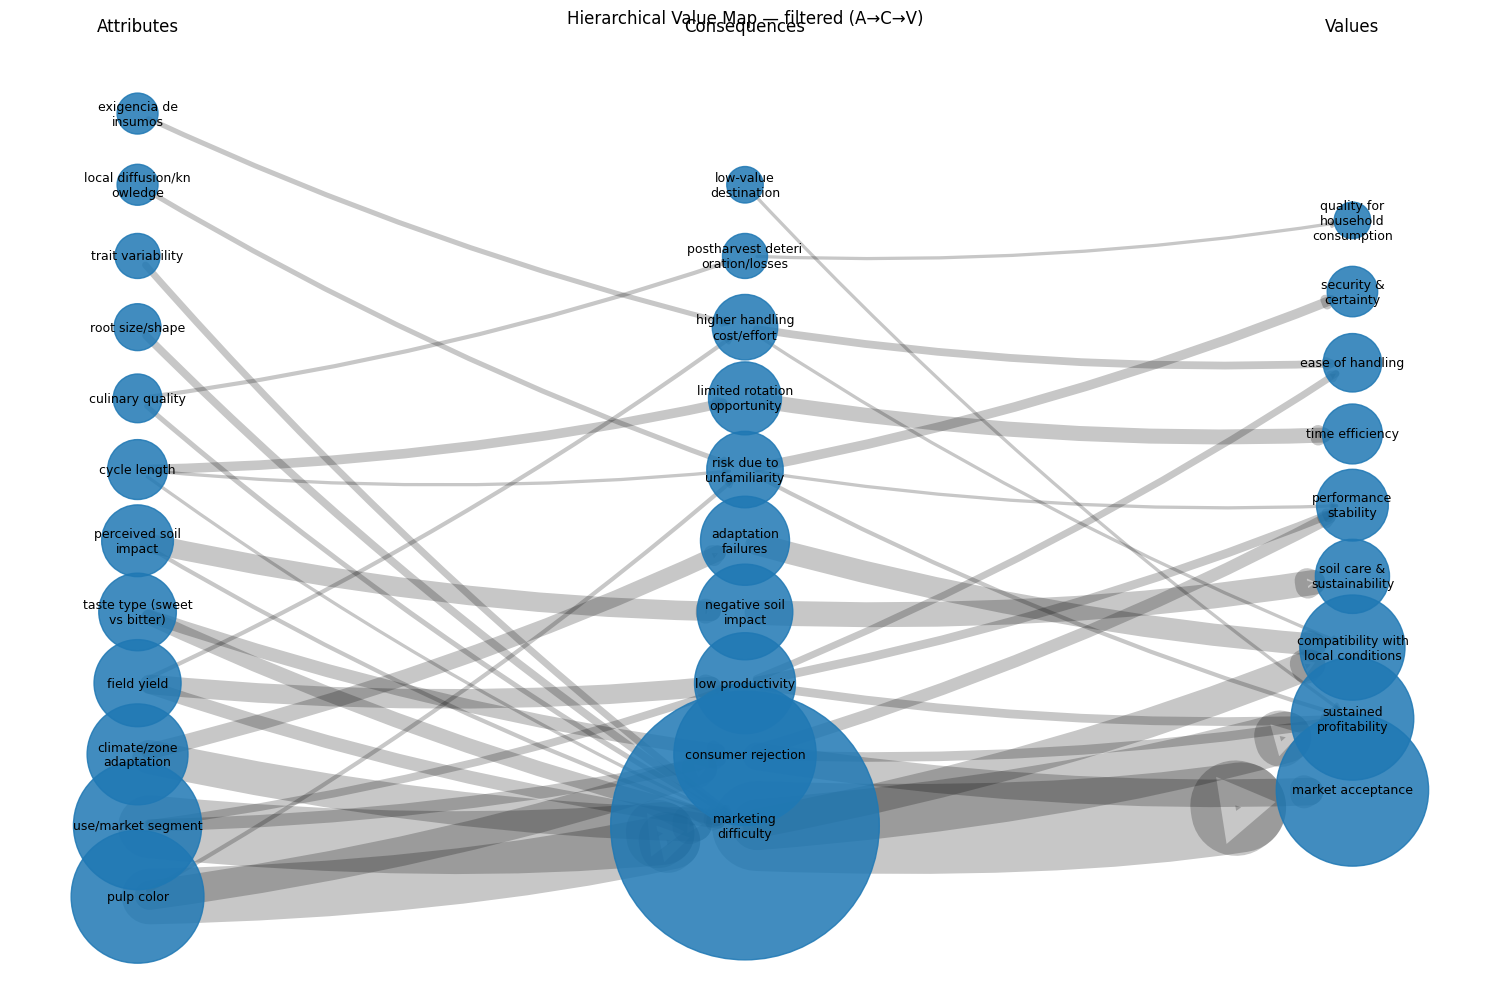

Saved: /content/mec_outputs_text_only/HVM_filtered_EN.png and /content/mec_outputs_text_only/HVM_filtered_EN.svg


In [17]:
import os, pandas as pd, numpy as np, textwrap
import networkx as nx
import matplotlib.pyplot as plt

outdir = "/content/mec_outputs_text_only"

# Carga aristas si hace falta
if 'edge_AC' not in globals() or 'edge_CV' not in globals():
    edge_AC = pd.read_csv(f"{outdir}/edge_list_AC.csv")
    edge_CV = pd.read_csv(f"{outdir}/edge_list_CV.csv")

# === Aplicar traducción ===
edge_AC_en = edge_AC.assign(A=edge_AC["A"].map(t), C=edge_AC["C"].map(t))
edge_CV_en = edge_CV.assign(C=edge_CV["C"].map(t), V=edge_CV["V"].map(t))

# Parámetros (ajústalos si necesitas más limpieza visual)
MIN_COUNT = 3
TOPK_PER_A = 3
TOPK_PER_C_to_V = 3
TOP_A = 12; TOP_C = 12; TOP_V = 9

NODE_BASE, NODE_K = 420, 90
EDGE_BASE, EDGE_K, EDGE_ALPHA, NODE_ALPHA = 0.4, 0.65, 0.22, 0.85
LABEL_WRAP, LABEL_SIZE = 18, 9

AC = edge_AC_en[edge_AC_en["count"]>=MIN_COUNT].copy()
CV = edge_CV_en[edge_CV_en["count"]>=MIN_COUNT].copy()
AC = (AC.sort_values(["A","count"], ascending=[True,False])
        .groupby("A", as_index=False).head(TOPK_PER_A))
CV = (CV.sort_values(["C","count"], ascending=[True,False])
        .groupby("C", as_index=False).head(TOPK_PER_C_to_V))

wA = AC.groupby("A")["count"].sum().sort_values(ascending=False)
wC = pd.concat([AC.groupby("C")["count"].sum(), CV.groupby("C")["count"].sum()], axis=1).fillna(0).sum(1).sort_values(ascending=False)
wV = CV.groupby("V")["count"].sum().sort_values(ascending=False)

A_keep = set(wA.head(TOP_A).index)
C_keep = set(wC.head(TOP_C).index)
V_keep = set(wV.head(TOP_V).index)

AC = AC[AC["A"].isin(A_keep) & AC["C"].isin(C_keep)]
CV = CV[CV["C"].isin(C_keep) & CV["V"].isin(V_keep)]
wA = AC.groupby("A")["count"].sum()
wC = pd.concat([AC.groupby("C")["count"].sum(), CV.groupby("C")["count"].sum()], axis=1).fillna(0).sum(1)
wV = CV.groupby("V")["count"].sum()

# Grafo en capas
G = nx.DiGraph()
for a in wA.index: G.add_node(("A",a), weight=wA[a])
for c in wC.index: G.add_node(("C",c), weight=wC[c])
for v in wV.index: G.add_node(("V",v), weight=wV[v])
for _, r in AC.iterrows(): G.add_edge(("A", r["A"]), ("C", r["C"]), weight=r["count"])
for _, r in CV.iterrows(): G.add_edge(("C", r["C"]), ("V", r["V"]), weight=r["count"])

def layered_positions(G, gap_x=4.6, gap_y=1.25):
    def sort_by_w(nodes):
        w = [G.nodes[n].get("weight",1.0) for n in nodes]
        order = np.argsort(-np.array(w))
        nodes_sorted = [nodes[i] for i in order]
        y = np.linspace(0, gap_y*(len(nodes_sorted)-1), len(nodes_sorted)) if nodes_sorted else []
        if len(y)>0: y = y - np.mean(y)
        return nodes_sorted, y
    A_nodes = [n for n in G.nodes() if n[0]=="A"]
    C_nodes = [n for n in G.nodes() if n[0]=="C"]
    V_nodes = [n for n in G.nodes() if n[0]=="V"]
    A_sorted, yA = sort_by_w(A_nodes); C_sorted, yC = sort_by_w(C_nodes); V_sorted, yV = sort_by_w(V_nodes)
    pos = {}
    for n,y in zip(A_sorted,yA): pos[n]=(0.0,y)
    for n,y in zip(C_sorted,yC): pos[n]=(4.6,y)
    for n,y in zip(V_sorted,yV): pos[n]=(9.2,y)
    return pos

pos = layered_positions(G)
def node_size(n): return NODE_BASE + NODE_K * G.nodes[n].get("weight",1.0)
labels = {n: "\n".join(textwrap.wrap(n[1], LABEL_WRAP)) for n in G.nodes()}
edge_w = [EDGE_BASE + EDGE_K*G[u][v]['weight'] for u,v in G.edges()]

plt.figure(figsize=(15,10))
nx.draw_networkx_nodes(G, pos, nodelist=[n for n in G.nodes() if n[0]=="A"],
                       node_size=[node_size(n) for n in G.nodes() if n[0]=="A"], alpha=NODE_ALPHA)
nx.draw_networkx_nodes(G, pos, nodelist=[n for n in G.nodes() if n[0]=="C"],
                       node_size=[node_size(n) for n in G.nodes() if n[0]=="C"], alpha=NODE_ALPHA)
nx.draw_networkx_nodes(G, pos, nodelist=[n for n in G.nodes() if n[0]=="V"],
                       node_size=[node_size(n) for n in G.nodes() if n[0]=="V"], alpha=NODE_ALPHA)
nx.draw_networkx_edges(G, pos, width=edge_w, arrows=True, arrowstyle="-|>",
                       alpha=EDGE_ALPHA, connectionstyle="arc3,rad=0.05")
nx.draw_networkx_labels(G, pos, labels=labels, font_size=9, verticalalignment='center')

# Encabezados de columnas en inglés
y_all = [y for (_,y) in pos.values()]; y_top = max(y_all) if len(y_all)>0 else 0
offset = (max(y_all)-min(y_all))*0.10 if len(y_all)>0 else 2.0
plt.text(0.0,  y_top+offset, "Attributes",   ha="center", va="bottom", fontsize=12)
plt.text(4.6,  y_top+offset, "Consequences", ha="center", va="bottom", fontsize=12)
plt.text(9.2,  y_top+offset, "Values",       ha="center", va="bottom", fontsize=12)

plt.title("Hierarchical Value Map — filtered (A→C→V)")
plt.axis("off"); plt.tight_layout(); plt.show()

# Guardar versiones EN
png = f"{outdir}/HVM_filtered_EN.png"; svg = f"{outdir}/HVM_filtered_EN.svg"
plt.figure(figsize=(15,10))
nx.draw_networkx_nodes(G, pos, nodelist=[n for n in G.nodes() if n[0]=="A"],
                       node_size=[node_size(n) for n in G.nodes() if n[0]=="A"], alpha=NODE_ALPHA)
nx.draw_networkx_nodes(G, pos, nodelist=[n for n in G.nodes() if n[0]=="C"],
                       node_size=[node_size(n) for n in G.nodes() if n[0]=="C"], alpha=NODE_ALPHA)
nx.draw_networkx_nodes(G, pos, nodelist=[n for n in G.nodes() if n[0]=="V"],
                       node_size=[node_size(n) for n in G.nodes() if n[0]=="V"], alpha=NODE_ALPHA)
nx.draw_networkx_edges(G, pos, width=edge_w, arrows=True, arrowstyle="-|>",
                       alpha=EDGE_ALPHA, connectionstyle="arc3,rad=0.05")
nx.draw_networkx_labels(G, pos, labels=labels, font_size=9, verticalalignment='center')
plt.text(0.0,  y_top+offset, "Attributes",   ha="center", va="bottom", fontsize=12)
plt.text(4.6,  y_top+offset, "Consequences", ha="center", va="bottom", fontsize=12)
plt.text(9.2,  y_top+offset, "Values",       ha="center", va="bottom", fontsize=12)
plt.title("Hierarchical Value Map — filtered (A→C→V)")
plt.axis("off"); plt.tight_layout()
plt.savefig(png, dpi=300, bbox_inches="tight"); plt.savefig(svg, bbox_inches="tight"); plt.close()
print("Saved:", png, "and", svg)


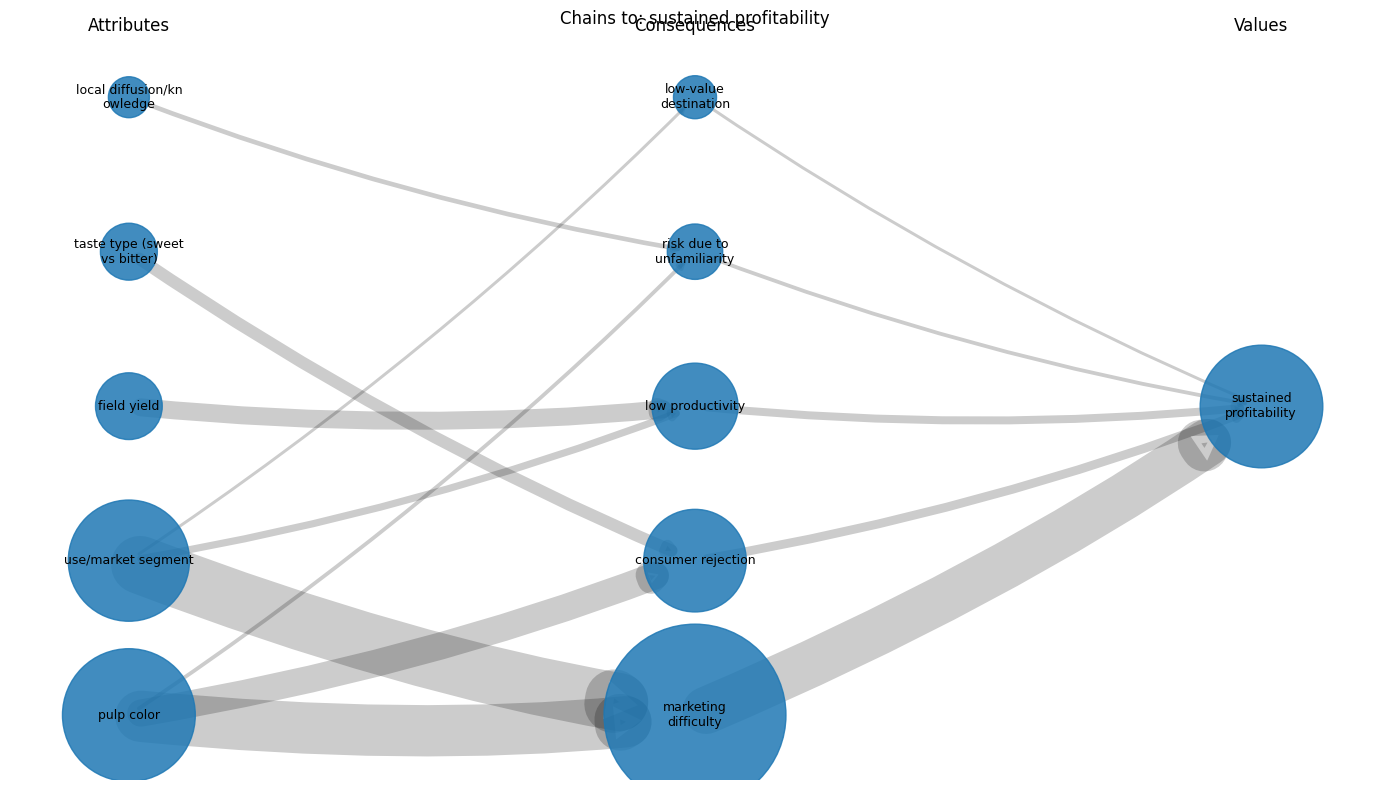

In [18]:
import pandas as pd, numpy as np, textwrap, networkx as nx, matplotlib.pyplot as plt

TARGET_VALUE_ES = "rentabilidad sostenida"      # escribe el nombre en español exacto
TARGET_VALUE_EN = t(TARGET_VALUE_ES)            # traducimos a EN para el gráfico

MIN_COUNT, TOP_C, TOP_A_per_C = 3, 6, 2
NODE_BASE, NODE_K = 420, 90
EDGE_BASE, EDGE_K, EDGE_ALPHA, NODE_ALPHA = 0.35, 0.60, 0.20, 0.85
LABEL_WRAP, LABEL_SIZE = 18, 9

# Filtrar y traducir aristas al vuelo
CV = edge_CV.copy()
CV = CV[CV["V"].str.lower() == TARGET_VALUE_ES.lower()]
CV["C"] = CV["C"].map(t); CV["V"] = CV["V"].map(t)
CV = CV[CV["count"]>=MIN_COUNT].sort_values("count", ascending=False).head(TOP_C)

C_sel = set(CV["C"])
AC = edge_AC.copy()
AC["A"] = AC["A"].map(t); AC["C"] = AC["C"].map(t)
AC = AC[AC["C"].isin(C_sel)]
AC = (AC[AC["count"]>=MIN_COUNT]
        .sort_values(["C","count"], ascending=[True,False])
        .groupby("C", as_index=False).head(TOP_A_per_C))

wA = AC.groupby("A")["count"].sum() if len(AC) else pd.Series(dtype=float)
wC = (AC.groupby("C")["count"].sum() if len(AC) else pd.Series(dtype=float)) + \
     (CV.groupby("C")["count"].sum() if len(CV) else pd.Series(dtype=float))
wV = CV.groupby("V")["count"].sum() if len(CV) else pd.Series(dtype=float)

G2 = nx.DiGraph()
for a in wA.index: G2.add_node(("A",a), weight=wA[a])
for c in wC.index: G2.add_node(("C",c), weight=wC[c])
for v in wV.index: G2.add_node(("V",v), weight=wV[v])
for _, r in AC.iterrows(): G2.add_edge(("A",r["A"]), ("C",r["C"]), weight=r["count"])
for _, r in CV.iterrows(): G2.add_edge(("C",r["C"]), ("V",r["V"]), weight=r["count"])

def layered_positions(G, gap_x=4.6, gap_y=1.25):
    def sort_by_w(nodes):
        w = [G.nodes[n].get("weight",1.0) for n in nodes]
        order = np.argsort(-np.array(w))
        nodes_sorted = [nodes[i] for i in order]
        y = np.linspace(0, gap_y*(len(nodes_sorted)-1), len(nodes_sorted)) if nodes_sorted else []
        if len(y)>0: y = y - np.mean(y)
        return nodes_sorted, y
    A_nodes = [n for n in G.nodes() if n[0]=="A"]
    C_nodes = [n for n in G.nodes() if n[0]=="C"]
    V_nodes = [n for n in G.nodes() if n[0]=="V"]
    A_sorted, yA = sort_by_w(A_nodes); C_sorted, yC = sort_by_w(C_nodes); V_sorted, yV = sort_by_w(V_nodes)
    pos = {}
    for n,y in zip(A_sorted,yA): pos[n]=(0.0,y)
    for n,y in zip(C_sorted,yC): pos[n]=(4.6,y)
    for n,y in zip(V_sorted,yV): pos[n]=(9.2,y)
    return pos

pos2 = layered_positions(G2)
def node_size(n): return NODE_BASE + NODE_K * G2.nodes[n].get("weight",1.0)
labels2 = {n: "\n".join(textwrap.wrap(n[1], LABEL_WRAP)) for n in G2.nodes()}
edge_w2 = [EDGE_BASE + EDGE_K*G2[u][v]['weight'] for u,v in G2.edges()]

plt.figure(figsize=(14,8))
nx.draw_networkx_nodes(G2, pos2, nodelist=[n for n in G2.nodes() if n[0]=="A"],
                       node_size=[node_size(n) for n in G2.nodes() if n[0]=="A"], alpha=NODE_ALPHA)
nx.draw_networkx_nodes(G2, pos2, nodelist=[n for n in G2.nodes() if n[0]=="C"],
                       node_size=[node_size(n) for n in G2.nodes() if n[0]=="C"], alpha=NODE_ALPHA)
nx.draw_networkx_nodes(G2, pos2, nodelist=[n for n in G2.nodes() if n[0]=="V"],
                       node_size=[node_size(n) for n in G2.nodes() if n[0]=="V"], alpha=NODE_ALPHA)
nx.draw_networkx_edges(G2, pos2, width=edge_w2, arrows=True, arrowstyle="-|>",
                       alpha=EDGE_ALPHA, connectionstyle="arc3,rad=0.05")
nx.draw_networkx_labels(G2, pos2, labels=labels2, font_size=LABEL_SIZE, verticalalignment='center')

y_all = [y for (_,y) in pos2.values()]; y_top = max(y_all) if len(y_all)>0 else 0
offset = (max(y_all)-min(y_all))*0.10 if len(y_all)>0 else 2.0
plt.text(0.0,  y_top+offset, "Attributes",   ha="center", va="bottom", fontsize=12)
plt.text(4.6,  y_top+offset, "Consequences", ha="center", va="bottom", fontsize=12)
plt.text(9.2,  y_top+offset, "Values",       ha="center", va="bottom", fontsize=12)

plt.title(f"Chains to: {TARGET_VALUE_EN}")
plt.axis("off"); plt.tight_layout(); plt.show()
